## Transaction is fraud or not?

In [9]:
# importing packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score, f1_score,confusion_matrix
from xgboost.sklearn import XGBClassifier
import lightgbm as lgb 
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import plot_importance, to_graphviz
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

In [10]:
# Loading dataset
df = pd.read_csv('../input/paysim1/PS_20174392719_1491204439457_log.csv')

### EDA

In [11]:
# Shape of dataset and top 5 rows
print(df.shape)
df.head()

(6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [12]:
# Checking is there any null values
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

According to above info there are no such feature which have null value

In [13]:
# features which have dtypes object
df.select_dtypes(include = ['object']).head(3)

,type,nameOrig,nameDest
0,PAYMENT,C1231006815,M1979787155
1,PAYMENT,C1666544295,M2044282225
2,TRANSFER,C1305486145,C553264065


In [14]:
# Features which have dtypes int and float
df.select_dtypes(include = ['int64','float64']).head(3)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0
2,1,181.00,181.0,0.00,0.0,0.0,1,0


In [15]:
# Statistics description of each features
df.describe().T

,count,mean,std,min,25%,50%,75%,max
step,6362620.0,2.433972e+02,1.423320e+02,1.0,156.00,239.000,3.350000e+02,7.430000e+02
amount,6362620.0,1.798619e+05,6.038582e+05,0.0,13389.57,74871.940,2.087215e+05,9.244552e+07
oldbalanceOrg,6362620.0,8.338831e+05,2.888243e+06,0.0,0.00,14208.000,1.073152e+05,5.958504e+07
newbalanceOrig,6362620.0,8.551137e+05,2.924049e+06,0.0,0.00,0.000,1.442584e+05,4.958504e+07
oldbalanceDest,6362620.0,1.100702e+06,3.399180e+06,0.0,0.00,132705.665,9.430367e+05,3.560159e+08
newbalanceDest,6362620.0,1.224996e+06,3.674129e+06,0.0,0.00,214661.440,1.111909e+06,3.561793e+08
isFraud,6362620.0,1.290820e-03,3.590480e-02,0.0,0.00,0.000,0.000000e+00,1.000000e+00
isFlaggedFraud,6362620.0,2.514687e-06,1.585775e-03,0.0,0.00,0.000,0.000000e+00,1.000000e+00


From above info we can get different type of stats description corresponding each features

0    6354407
1       8213
Name: isFraud, dtype: int64


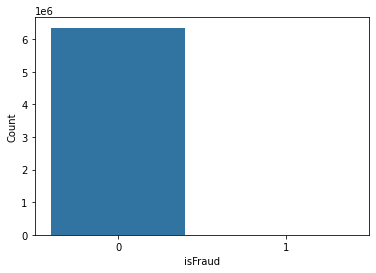

In [16]:
# count number of fraud and not fraud data
print(df.isFraud.value_counts())
sns.countplot(data=df, x='isFraud')
plt.ylabel('Count')
plt.show()

Total number of data point is 6362620 in which 8213 is fraud and 6354407 is not fraud data point.

Which means this is imbalanced datatset.

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64


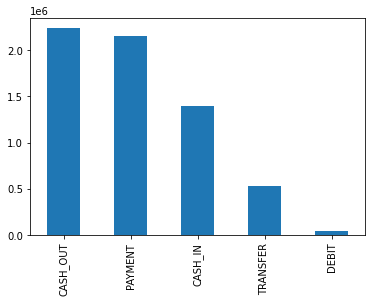

In [17]:
# Count number of data point in each type of transaction
print(df.type.value_counts())
df.type.value_counts().plot(kind='bar')
plt.show()

In [18]:
# Investigate variable "isFlaggedFraud"
pd.crosstab(df.isFraud,df.isFlaggedFraud)

isFlaggedFraud,0,1
isFraud,,
0,6354407,0
1,8197,16


In [19]:
#Groupby type
df.groupby('type')['isFraud','isFlaggedFraud'].sum()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,isFraud,isFlaggedFraud
type,,
CASH_IN,0,0
CASH_OUT,4116,0
DEBIT,0,0
PAYMENT,0,0
TRANSFER,4097,16


1. Fraud occurs only in 2 type of transactions: 
  - TRANSFER and 
  - CASH_OUT


2. The number of fraudulent TRANSFERs = 4097

3. The number of fraudulent CASH_OUTs = 4116

4. The type of transactions in which isFlaggedFraud is set : TRANSFER

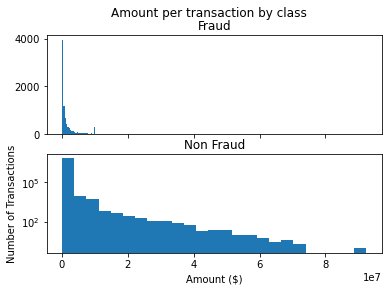

In [20]:
# Amount Vs number of transaction
fraud = df[df['isFraud']==1]
normal = df[df['isFraud']==0]
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')
bins = 25
ax1.hist(fraud.amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(normal.amount, bins = bins)
ax2.set_title('Non Fraud')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
# plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

Less number of transaction amount in fraud comapare to non fraud data

### Feature Engineering and Preprocessing

In [21]:
%%time
# Copy from Arjun Joshua
# Feature extraction
data = df.copy()

# Merchant flag for source and dist
data['OrigC']=data['nameOrig'].apply(lambda x: 1 if str(x).find('C')==0 else 0)
data['DestC']=data['nameDest'].apply(lambda x: 1 if str(x).find('C')==0 else 0)

# flag for transfer and cashout from type feature
data['TRANSFER']=data['type'].apply(lambda x: 1 if x=='TRANSFER' else 0)
data['CASH_OUT']=data['type'].apply(lambda x: 1 if x=='CASH_OUT' else 0)

CPU times: user 19.4 s, sys: 923 ms, total: 20.3 s
Wall time: 20.3 s


In [22]:
# Calculating Amount error
data['OrigAmntErr']=(abs(data.oldbalanceOrg-data.newbalanceOrig)-data.amount)

In [23]:
# drop list 
# droping those feature which are id type category and those which used for feature extraction
droplist=['isFlaggedFraud','type','nameDest','nameOrig']

In [24]:
#print result
def model_result(clf,x_test,y_test):
    y_prob=clf.predict_proba(x_test)
    y_pred=clf.predict(x_test)
    print('AUPRC :', (average_precision_score(y_test, y_prob[:, 1])))
    print('F1 - score :',(f1_score(y_test,y_pred)))
    print('Confusion_matrix : ')
    print(confusion_matrix(y_test,y_pred))
    print("accuracy_score")
    print(accuracy_score(y_test,y_pred))
    print("classification_report")
    print(classification_report(y_test,y_pred))


In [25]:
# droping feature which is in droplist
# Creating X and y for spliting dataset into test and train
MLData=data.drop(labels=droplist,axis=1)
X=MLData.drop('isFraud',axis=1)
Y=MLData.isFraud

In [26]:
# splinting data into X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3,random_state=42, shuffle=False)

### ML Model

**Performance Metric selection:** 

- Since the data is highly skewed, I am using the area under the precision-recall curve (AUPRC) rather than the conventional area under the receiver operating characteristic (AUROC).[refer](http://pages.cs.wisc.edu/~jdavis/davisgoadrichcamera2.pdf)
- F1 score is the harmonic mean of the precision and recall. The highest possible value of F1 is 1, indicating perfect precision and recall, and the lowest possible value is 0, if either the precision or the recall is zero.[wiki](https://en.wikipedia.org/wiki/F1_score)
- We should do more focus on FP & FN.

**ML algorithm selection:** 

1. A first approach to deal with imbalanced data is to balance it by discarding the majority class before applying an ML algorithm. The disadvantage of undersampling is that a model trained in this way will not perform well on real-world skewed test data since almost all the information was discarded. 

2. A second approach might be to oversample the minority class, say by the synthetic minority oversampling technique (SMOTE) contained in the 'imblearn' library.

3. I find, however, that the best result is obtained on the original dataset by using a ML algorithm based on ensembles of decision trees that intrinsically performs well on imbalanced data. Such algorithms not only allow for constructing a model that can cope with the missing values in our data, but they naturally allow for speedup via parallel-processing. Among these algorithms, XGBoost and random-forest algorithm used below slightly outperforms. Finally, XGBoost, RF, like several other ML algorithms, allows for weighting the positive class more compared to the negative class.

#### XGBoost with class weights

In [27]:
%%time

weights = (Y == 0).sum() / (1.0 * (Y == 1).sum()) # giving class weight
clf = XGBClassifier( scale_pos_weight = weights, n_jobs = 4, random_state=42)
clf.fit(X_train, y_train)
print ('Test')
model_result(clf,X_test,y_test)

[18:58:39] WARNING: ../src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
Test
AUPRC : 0.9999986634851786
F1 - score : 0.9996717365138418
Confusion_matrix : 
[[1904215       1]
 [      2    4568]]
accuracy_score
0.9999984283204089
classification_report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1904216
           1       1.00      1.00      1.00      4570

    accuracy                           1.00   1908786
   macro avg       1.00      1.00      1.00   1908786
weighted avg       1.00      1.00      1.00   1908786

CPU times: user 32min 39s, sys: 15 s, total: 32min 54s
Wall time: 8min 51s


**Summary:**

In above model we are giving weight for fraud transaction label.

If we see all performance matrix is excellent.

So, the main focus parameter is FN & FP due to skew data.
- Number of FP point is 1
- Number of FN point is 2

#### XGBoost without class weights

In [28]:
%%time
clf2 = XGBClassifier()
clf2.fit(X_train, y_train)
print ('Test')
model_result(clf2,X_test,y_test)

[19:07:29] WARNING: ../src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
Test
AUPRC : 0.999983387914339
F1 - score : 0.9996717365138418
Confusion_matrix : 
[[1904215       1]
 [      2    4568]]
accuracy_score
0.9999984283204089
classification_report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1904216
           1       1.00      1.00      1.00      4570

    accuracy                           1.00   1908786
   macro avg       1.00      1.00      1.00   1908786
weighted avg       1.00      1.00      1.00   1908786

CPU times: user 30min 7s, sys: 13.8 s, total: 30min 20s
Wall time: 8min 13s


**Summary:**

In above model we are not giving any weight for fraud transaction label.

All performance matrix is giving excellent results.

So, the main focus parameter is FN & FP due to skew data.
- Number of FP point is 1
- Number of FN point is 2

#### XGBoost without class weights and test size is 40 perc

In [29]:
#split with 40 % of test size
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.4,random_state=42, shuffle=False)

In [30]:
%%time
clf3 = XGBClassifier()
clf3.fit(X_train, y_train)
print ('Test')
model_result(clf3,X_test,y_test)

Test
AUPRC : 0.99999992077039
F1 - score : 0.9998009157873781
Confusion_matrix : 
[[2540024       0]
 [      2    5022]]
accuracy_score
0.9999992141602044
classification_report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   2540024
           1       1.00      1.00      1.00      5024

    accuracy                           1.00   2545048
   macro avg       1.00      1.00      1.00   2545048
weighted avg       1.00      1.00      1.00   2545048

CPU times: user 19min 39s, sys: 11.2 s, total: 19min 50s
Wall time: 5min 15s


**Summary:**

In above model we are giving weight for fraud transaction label.

Spliting data into 60-40 train-test

All performance matrix is giving excellent results.

So, the main focus parameter is FN & FP due to skew data.
- Number of FP point is 0
- Number of FN point is 2

#### Random Forest

In [31]:
#split with 30 % of test size
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3,random_state=42, shuffle=False)

In [32]:
%%time
from sklearn.ensemble import RandomForestClassifier
r_clf=RandomForestClassifier()
r_clf.fit(X_train,y_train)
print ('Test')
model_result(r_clf,X_test,y_test)

Test
AUPRC : 0.9999999042789236
F1 - score : 0.9997811337272926
Confusion_matrix : 
[[1904216       0]
 [      2    4568]]
accuracy_score
0.9999989522136059
classification_report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1904216
           1       1.00      1.00      1.00      4570

    accuracy                           1.00   1908786
   macro avg       1.00      1.00      1.00   1908786
weighted avg       1.00      1.00      1.00   1908786

CPU times: user 13min 56s, sys: 8.79 s, total: 14min 5s
Wall time: 14min 6s


**Summary:**

In above model we are using as it as dataset.

All performance matrix is giving excellent results.

So, the main focus parameter is FN & FP due to skew data.
- Number of FP point is 0
- Number of FN point is 1

## Conclusion

Thoroughly interrogated the data with the help of EDA and go insight the data.

Generated new features with the help of existing features

To deal with the large skew in the data, we chose an appropriate metric and used an ML algorithm based on an ensemble of decision trees which works best with strongly imbalanced classes.

Tried different different ML model with upsampling and downsampling of data with the help of **imblearn** and **SMOTE** but

Random Forest with full dataset is giving best result comapring to all ML model.